In [148]:
import matplotlib
import torch
import torch.nn.functional as F
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
from IPython.display import clear_output
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from celluloid import Camera

In [149]:
# Define the number of previous positions to remember (trail length)
trail_length = 15  # You can adjust this value as needed

# Create lists to store previous positions
prev_positions1 = []
prev_positions2 = []

def animate(i):
    # Clear the plot
    ax.cla()

    # Get the angles for the current time step
    theta1 = to_plot[i, 0].item()
    theta2 = to_plot[i, 1].item()

    # Convert angles to tensors
    theta1 = torch.tensor(theta1)
    theta2 = torch.tensor(theta2)

    # Compute the Cartesian coordinates of the pendulum
    x1 = l1 * torch.sin(theta1)
    y1 = -l1 * torch.cos(theta1)
    x2 = x1 + l2 * torch.sin(theta2)
    y2 = y1 - l2 * torch.cos(theta2)

    # Store the current positions in the lists
    prev_positions1.append((x1, y1))
    prev_positions2.append((x2, y2))

    # Limit the length of the trail to the specified trail_length
    if len(prev_positions1) > trail_length:
        prev_positions1.pop(0)
        prev_positions2.pop(0)

    # Plot the trailing lines
    for j in range(len(prev_positions1) - 1):
        ax.plot([prev_positions1[j][0], prev_positions1[j + 1][0]],
                [prev_positions1[j][1], prev_positions1[j + 1][1]], 'b-', lw=1, alpha=0.7)  # Trailing line for Mass 1
        ax.plot([prev_positions2[j][0], prev_positions2[j + 1][0]],
                [prev_positions2[j][1], prev_positions2[j + 1][1]], 'r-', lw=1, alpha=0.7)  # Trailing line for Mass 2

    # Plot the pendulum
    ax.plot([0, x1], [0, y1], 'b-', lw=2)  # Rod 1
    ax.plot(x1, y1, 'bo', markersize=5)    # Mass 1
    ax.plot([x1, x2], [y1, y2], 'b-', lw=2)  # Rod 2
    ax.plot(x2, y2, 'ro', markersize=5)    # Mass 2
    
    
    # Set plot limits and aspect ratio
    ax.set_xlim(-l1 - l2 - 0.5, l1 + l2 + 0.5)
    ax.set_ylim(-l1 - l2 - 0.5, l1 + l2 + 0.5)
    ax.set_aspect('equal', adjustable='box')
    

In [150]:
class DoublePendulumODE(torch.nn.Module):
    def forward(self, t, z):
        """
        Defines the equations of motion for the double pendulum.

        Arguments:
        t: The independent variable (time).
        z: The state vector z = [theta1, theta2, p1, p2] where
            theta1, theta2: The angles of the pendulums.
            p1, p2: The angular momenta of the pendulums.

        Returns:
        dzdt: The time derivatives of the state vector z.
        """
        theta1, theta2, p1, p2 = z
        m1 = 0.5  # mass of pendulum 1
        m2 = 0.5  # mass of pendulum 2
        g = 9.8  # acceleration due to gravity
        l1 = 1.0  # length of pendulum 1
        l2 = 1.0  # length of pendulum 2

        # Convert angles to radians
        theta1_rad = torch.deg2rad(theta1)
        theta2_rad = torch.deg2rad(theta2)

        # Equations of motion
        theta1_dot = p1 / (m1 * l1 ** 2)
        theta2_dot = p2 / (m2 * l2 ** 2)

        p1_dot = (
            -m2 * l1 * l2 * theta2_dot ** 2 * torch.sin(theta1_rad - theta2_rad)
            - (m1 + m2) * g * torch.sin(theta1_rad) / l1
        )
        p2_dot = (
            m2 * l1 * l2 * theta1_dot ** 2 * torch.sin(theta1_rad - theta2_rad)
            - m2 * g * torch.sin(theta2_rad) / l2
        )

        dzdt = torch.tensor([theta1_dot, theta2_dot, p1_dot, p2_dot])
        return dzdt

In [151]:
torch.manual_seed(7)
np.random.seed(7)

In [152]:
# def generate_random_initial_conditions(num_conditions):
#     # Generate random values for theta1, theta2, p1, and p2 within specified ranges
#     theta1 = torch.rand(num_conditions) * (2 * torch.tensor(np.pi))  # Random angles between 0 and 2*pi
#     theta2 = torch.rand(num_conditions) * (2 * torch.tensor(np.pi))  # Random angles between 0 and 2*pi
#     p1 = torch.rand(num_conditions) * 2 - 1  # Random values between -1 and 1
#     p2 = torch.rand(num_conditions) * 2 - 1  # Random values between -1 and 1
    
#     return torch.stack([theta1, theta2, p1, p2], dim=1) 

In [153]:
# random_initial_conditions = generate_random_initial_conditions(10)

In [154]:
# random_initial_conditions

In [155]:
# data = []
# t = torch.linspace(0, 100, 1000)
# for z0 in random_initial_conditions:
#     true = odeint(DoublePendulumODE(), z0, t,method='rk4')
#     data.append(true)

In [156]:
# data = torch.stack(data, dim=0)

In [157]:
# data.shape

In [158]:
# import os
# torch.save(data, 'Data/pendulum_data.pt')

In [159]:
data = torch.load('Data/pendulum_data.pt')

In [160]:
train = data[:6]
val = data[6]
test = data[7:]

In [161]:
# for k in range(len(data)):
#     to_plot = data[k]
#     fig, ax = plt.subplots()
#     animation = FuncAnimation(fig, animate, frames=len(t), interval=50)
#     animation.save(f'pendulum{k}.gif', writer='PillowWriter', fps=30)

In [202]:
l1 = 1.0
l2 = 1.0
t = torch.linspace(0, 100, 1000)

In [163]:
# Initial conditions
z0 = torch.tensor([2.4435, 2.0944, 0., 0.])  # [theta1, theta2, p1, p2]
# Pendulum lengths
l1 = 1.0
l2 = 1.0
# Time points
# Solve the ODE
single_view = odeint(DoublePendulumODE(), z0, t,method='rk4')

In [243]:
def visualise(to_plot,tt=None,masses=False,angles=False,idx=0,label=''):
    
    if masses is not False:
        if tt is None:
            # Extract the angles
            theta1 = to_plot[:, 0]
            theta2 = to_plot[:, 1]  
            theta1_trajectory = []
            theta2_trajectory = []
            x1_trajectory = []
            y1_trajectory = []
            x2_trajectory = []
            y2_trajectory = []

            # Store the trajectories
            for i in range(len(t)):
                theta1_trajectory.append(theta1[i].item())
                theta2_trajectory.append(theta2[i].item())

                # Compute the Cartesian coordinates of the pendulum
                x1 = l1 * torch.sin(theta1[i])
                y1 = -l1 * torch.cos(theta1[i])
                x2 = x1 + l2 * torch.sin(theta2[i])
                y2 = y1 - l2 * torch.cos(theta2[i])

                # Append coordinates to the trajectory lists
                x1_trajectory.append(x1.item())
                y1_trajectory.append(y1.item())
                x2_trajectory.append(x2.item())
                y2_trajectory.append(y2.item())

            # Create a separate figure and axes for the paths of the masses
            
            fig_paths, ax_paths = plt.subplots()
            # Plot the paths of the masses
            ax_paths.plot(x1_trajectory, y1_trajectory, 'b-', label='Mass 1')
            ax_paths.plot(x2_trajectory, y2_trajectory, 'r-', label='Mass 2')
            ax_paths.set_xlabel('x')
            ax_paths.set_ylabel('y')
            ax_paths.set_title(f'Paths of Masses {label} Set {idx}')
            ax_paths.legend()
            #plt.title(f'Paths of Masses Test set {idx}')
            plt.savefig(f'PNG/NODE/Paths of Masses on {label} Set {idx}.png')
            # Display the paths plot
            plt.show()
        if tt is not None:
            # Extract the angles for the test set
            theta1 = to_plot[:, 0]
            theta2 = to_plot[:, 1]  
            theta1_trajectory = []
            theta2_trajectory = []
            x1_trajectory = []
            y1_trajectory = []
            x2_trajectory = []
            y2_trajectory = []

            # Store the trajectories
            for i in range(len(t)):
                theta1_trajectory.append(theta1[i].item())
                theta2_trajectory.append(theta2[i].item())

                # Compute the Cartesian coordinates of the pendulum
                x1 = l1 * torch.sin(theta1[i])
                y1 = -l1 * torch.cos(theta1[i])
                x2 = x1 + l2 * torch.sin(theta2[i])
                y2 = y1 - l2 * torch.cos(theta2[i])

                # Append coordinates to the trajectory lists
                x1_trajectory.append(x1.item())
                y1_trajectory.append(y1.item())
                x2_trajectory.append(x2.item())
                y2_trajectory.append(y2.item())

            # Extract the angles for the test set
            theta3 = tt[:, 0]
            theta4 = tt[:, 1]  
            theta3_trajectory = []
            theta4_trajectory = []
            x3_trajectory = []
            y3_trajectory = []
            x4_trajectory = []
            y4_trajectory = []

            # Store the trajectories
            for i in range(len(t)):
                theta3_trajectory.append(theta3[i].item())
                theta4_trajectory.append(theta4[i].item())

                # Compute the Cartesian coordinates of the pendulum
                x3 = l1 * torch.sin(theta3[i])
                y3 = -l1 * torch.cos(theta3[i])
                x4 = x3 + l2 * torch.sin(theta4[i])
                y4 = y3 - l2 * torch.cos(theta4[i])

                # Append coordinates to the trajectory lists
                x3_trajectory.append(x3.item())
                y3_trajectory.append(y3.item())
                x4_trajectory.append(x4.item())
                y4_trajectory.append(y4.item())

            fig, axs = plt.subplots(2, 2, figsize=(12, 8))

            # Plot the paths of Mass 1 and Mass 2 for the original simulation on the first subplot
            axs[0, 0].plot(x1_trajectory, y1_trajectory, 'b-', label='Mass 1')
            axs[0, 0].plot(x2_trajectory, y2_trajectory, 'r-', label='Mass 2')
            axs[0, 0].set_xlabel('x')
            axs[0, 0].set_ylabel('y')
            axs[0, 0].set_title(f'Paths of Mass Simulation {label} Set {idx}')
            axs[0, 0].legend()

            # Plot the paths of Mass 1 and Mass 2 for the test set on the second subplot
            axs[0, 1].plot(x3_trajectory, y3_trajectory, 'b-', label='Mass 1')
            axs[0, 1].plot(x4_trajectory, y4_trajectory, 'r-', label='Mass 2')
            axs[0, 1].set_xlabel('x')
            axs[0, 1].set_ylabel('y')
            axs[0, 1].set_title(f'Paths of Masses {label} Set {idx}')
            axs[0, 1].legend()

            # Remove the third and fourth empty subplot
            fig.delaxes(axs[1, 0])
            fig.delaxes(axs[1, 1])

            # Adjust the layout for better spacing
            plt.tight_layout()

            # Save the figure with both subplots
            plt.savefig(f'PNG/NODE/Paths_of_Masses_on_{label}_Set_{idx}.png')

            # Display the plots
            plt.show()
    if angles is not False:
        p1 = to_plot[:, 0].detach().numpy()
        p2 = to_plot[:, 1].detach().numpy()
        theta1 = tt[:, 0].detach().numpy()
        theta2 = tt[:, 1].detach().numpy()

        # Create separate plots for theta1 and theta2
        plt.figure(figsize=(10,5))

        plt.subplot(1, 2, 1)
        plt.plot(t, theta1, label='Solution')
        plt.plot(t, p1, linestyle='dotted', label='Prediction')
        plt.xlabel('Time')
        plt.ylabel('Theta1')
        plt.title(f'Projection of Theta1 on {label} Set {idx}')
        plt.legend()

        # Plot for theta2
        plt.subplot(1, 2, 2)
        plt.plot(t, theta2, label='Solution')
        plt.plot(t, p2, linestyle='dotted', label='Prediction')
        plt.xlabel('Time')
        plt.ylabel('Theta2')
        plt.title(f'Projection of Theta-2 on {label} Set {idx}')
        plt.legend()

        # Adjust subplot spacing
        plt.tight_layout()
        
        plt.savefig(f'PNG/NODE/Projection of Theta-1 and Theta2 on {label}_{idx}.png')
        # Display the plots
        plt.show()

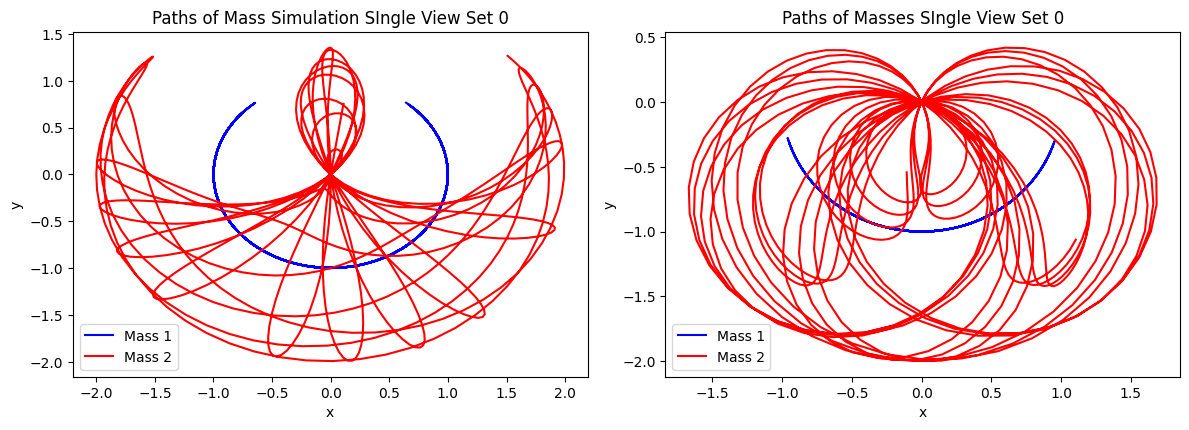

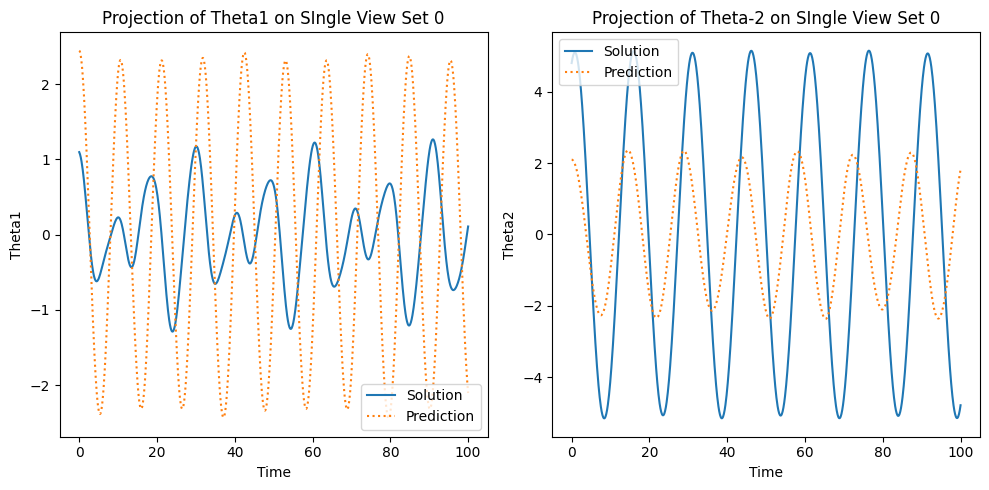

In [244]:
visualise(single_view,test[0],masses=True,idx=0,angles=True,label='SIngle View')

In [166]:
# to_plot = single_view

In [167]:
# # Create a figure and axes
# fig, ax = plt.subplots()
# # Animate the pendulum
# animation = FuncAnimation(fig, animate, frames=len(t), interval=50)

# # Convert animation to HTML
# html_animation = animation.to_jshtml()

# # Display the animation
# HTML(html_animation)

In [168]:
class PendulumTrain(nn.Module):
    """
    neural network for learning the chaotic lorenz system
    """
    def __init__(self):
        super(PendulumTrain, self).__init__()
        self.lin = nn.Linear(4, 256)
        self.lin2 = nn.Linear(256, 512)
        self.lin3 = nn.Linear(512, 4)
        self.lrelu = nn.LeakyReLU()

    def forward(self, t, x):
        x = self.lrelu(self.lin(x))
        x = self.lrelu(self.lin2(x))
        x = self.lin3(x)
        return x
     

In [169]:
val.shape

torch.Size([1000, 4])

In [170]:
train = train.view(6000,4)

In [171]:
func = PendulumTrain()

In [172]:
optimizer = optim.Adam(func.parameters(), lr=1e-2)

In [173]:
def get_batch(true_y, batch_size):
    num_samples = len(true_y)
    indices = np.random.choice(np.arange(num_samples - batch_size, dtype=np.int64), size=batch_size, replace=False)
    indices.sort()
    batch_y0 = true_y[indices]  # (batch_size, D)
    batch_t = t[:batch_size]  # (batch_size)
    batch_y = torch.stack([true_y[indices + i] for i in range(batch_size)], dim=0)  # (batch_size, M, D)
    return batch_y0, batch_t, batch_y

In [174]:
epoch_losses = []
val_losses = []
best_loss = 1000.
best_whole_loss = 1000.
for itr in range(1, 3000 + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(train,50)  # getting trajectory batch
    pred_y = odeint(func, batch_y0, batch_t)  # prediction using batch initial condition and batch time stamps
    loss = F.mse_loss(pred_y, batch_y)
    loss.backward()
    optimizer.step()
    epoch_loss = loss.item()
    epoch_losses.append(epoch_loss)
    if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(func.state_dict(), 'saved_models/double_pendulum.pth')
    if itr % 100 == 0:
        if itr > 1800:
            optimizer.param_groups[0]['lr'] = 1e-3
        with torch.no_grad():
            
            pred_y = odeint(func, val[0], t)
            loss = F.mse_loss(pred_y, val)
            val_loss = loss.item()
            val_losses.append(val_loss)
            print('Iter {:04d} | Epoch Loss {:.6f}'.format(itr, epoch_loss))
            print('Iter {:04d} | Val Loss {:.6f}'.format(itr, val_loss))
            visualise(pred_y,val,masses=True,idx=itr,angles=True)
            clear_output(wait=True)


Iter 0100 | Epoch Loss 4.392127
Iter 0100 | Val Loss 2.611017
Iter 0200 | Epoch Loss 4.456264
Iter 0200 | Val Loss 2.731858
Iter 0300 | Epoch Loss 1.952516
Iter 0300 | Val Loss 3.287754
Iter 0400 | Epoch Loss 0.567669
Iter 0400 | Val Loss 2.888898
Iter 0500 | Epoch Loss 0.092067
Iter 0500 | Val Loss 0.322150
Iter 0600 | Epoch Loss 0.412715
Iter 0600 | Val Loss 0.864899
Iter 0700 | Epoch Loss 0.123974
Iter 0700 | Val Loss 1.633438
Iter 0800 | Epoch Loss 0.324064
Iter 0800 | Val Loss 0.099015
Iter 0900 | Epoch Loss 0.204604
Iter 0900 | Val Loss 1.303856
Iter 1000 | Epoch Loss 0.209036
Iter 1000 | Val Loss 1.828610
Iter 1100 | Epoch Loss 0.215071
Iter 1100 | Val Loss 1.113241
Iter 1200 | Epoch Loss 0.282904
Iter 1200 | Val Loss 0.537940
Iter 1300 | Epoch Loss 0.058293
Iter 1300 | Val Loss 4.320799
Iter 1400 | Epoch Loss 0.083998
Iter 1400 | Val Loss 1.315983
Iter 1500 | Epoch Loss 0.199200
Iter 1500 | Val Loss 5.746315
Iter 1600 | Epoch Loss 0.129782
Iter 1600 | Val Loss 1.622058
Iter 170

In [245]:
def evaluate(model,test_data,t,visualizer = visualise,label=''):
    test_losses = []
    preds = []
    with torch.no_grad():
        for i in range(len(test_data)):
            pred_y = odeint(model, test_data[i][0], t)
            loss = F.mse_loss(pred_y, test_data[i])
            test_losses.append(loss.item())
            preds.append(pred_y)
            
            visualizer(pred_y,test_data[i],idx=i,masses=True,angles=True,label=label)
    return test_losses,preds

In [176]:
test.shape

torch.Size([3, 1000, 4])

In [177]:
import os

In [178]:
test_model = PendulumTrain()

In [179]:
test_model.load_state_dict(torch.load('saved_models/double_pendulum.pth'))

<All keys matched successfully>

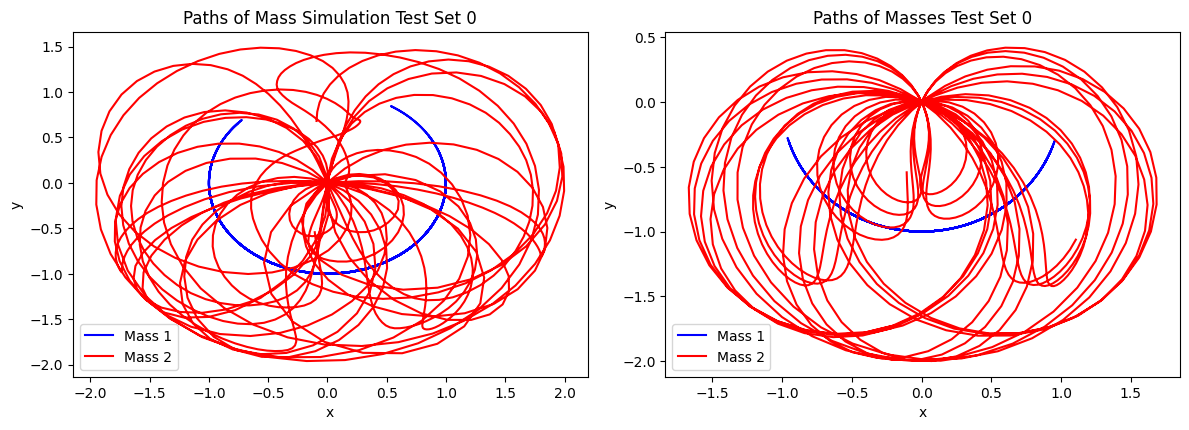

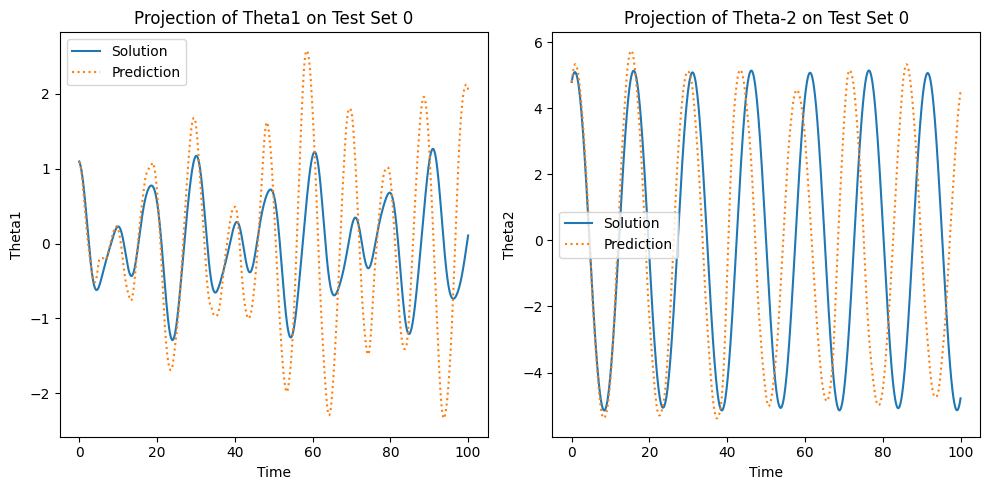

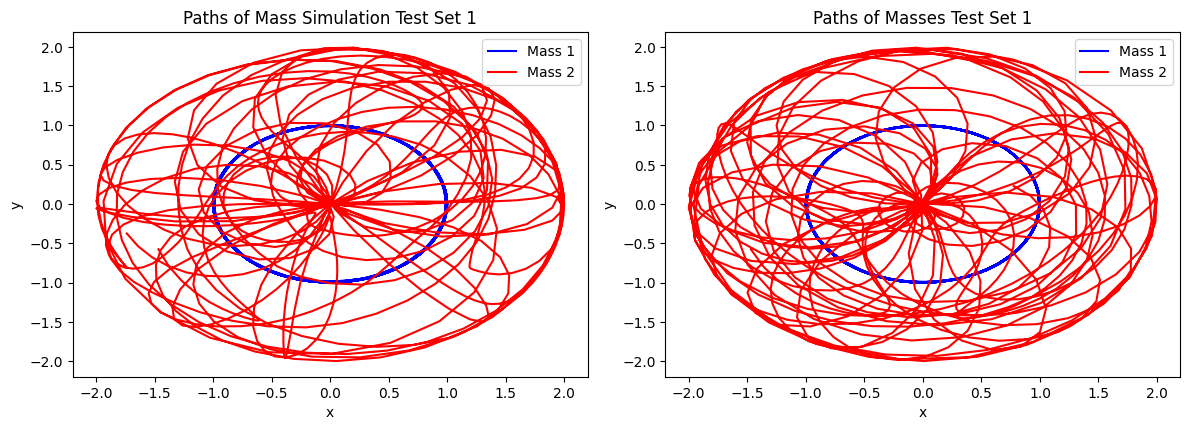

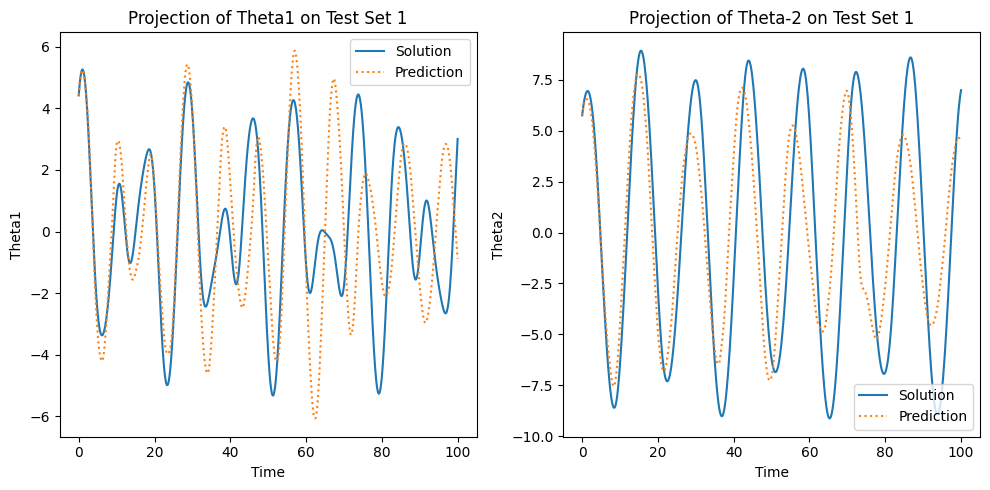

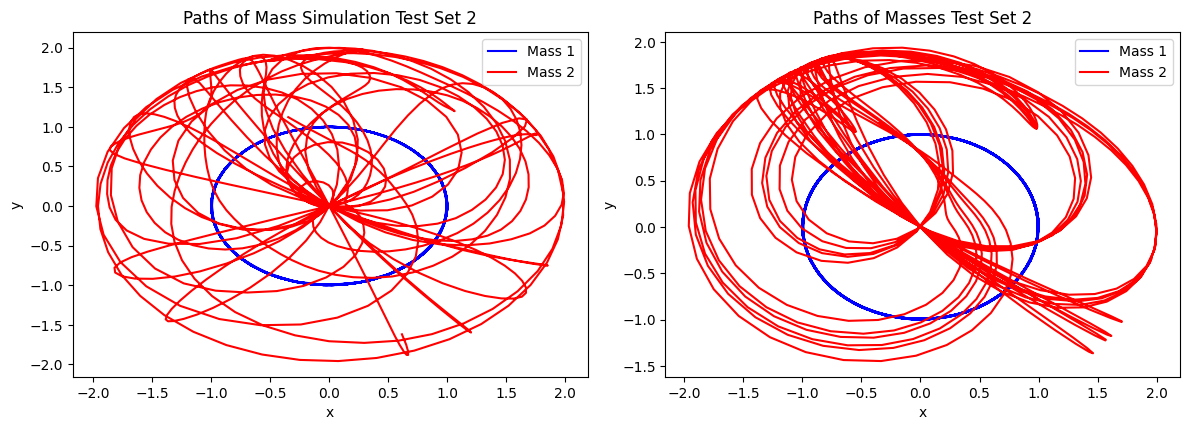

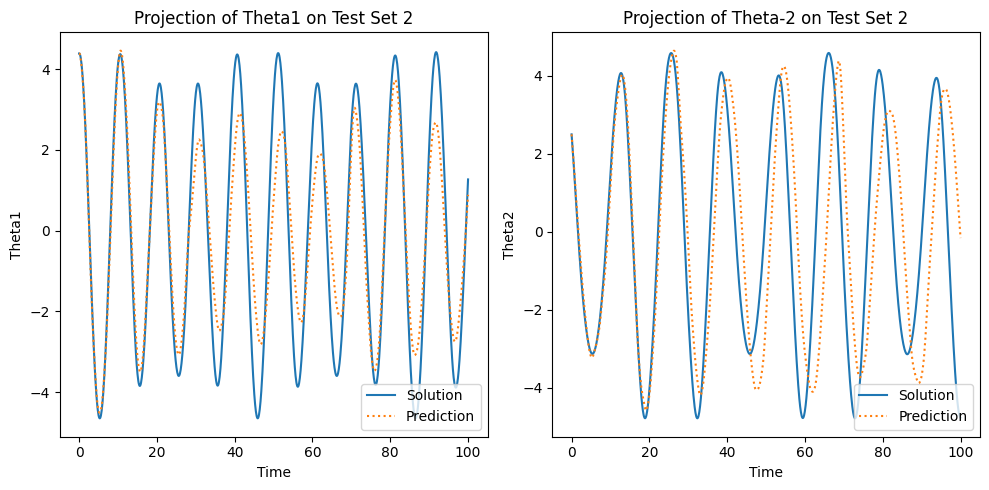

In [246]:
losses,preds = evaluate(test_model,test,t,label='Test')

In [185]:
# test_model = PendulumTrain()

In [186]:
# test_model.load_state_dict(torch.load('saved_models/double_val_pendulum.pth'))

In [187]:
train = data[:6]

In [216]:
train.shape

torch.Size([6, 1000, 4])

In [247]:
def plot_vector_field(pred,label):
    for idx in range(len(pred)):
        positions = pred[idx][:,:2]  # Extracting the 3 components as positions

        # Create a new tensor with requires_grad=True
        positions = positions.clone().detach().requires_grad_(True)

        # Calculate the vector field by taking the derivatives of positions
        vector_field = torch.autograd.grad(positions, positions, torch.ones_like(positions), create_graph=True)[0]

        # Extract the x, y, and z components of the vector field
        U = vector_field[:, 0]
        V = vector_field[:, 1]
        

        # Move tensors to CPU before converting to NumPy arrays
        positions = positions.cpu().detach().numpy()
        U = U.cpu().detach().numpy()
        V = V.cpu().detach().numpy()
        

        # Create a subset of positions for the arrows
        arrow_step = 1  # Adjust this to change the density of arrows
        arrow_positions = positions[::arrow_step]

        # Calculate arrow directions by normalizing the vector field components
        magnitude = np.sqrt(U**2 + V**2)
        arrow_U = U / magnitude
        arrow_V = V / magnitude

        # Plot the vector field with arrows
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.quiver(arrow_positions[:, 0], arrow_positions[:, 1], arrow_U[::arrow_step], arrow_V[::arrow_step], width=0.004, alpha=0.6)
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        ax.set_xlabel('')   # Remove x-axis label
        ax.set_ylabel('')   # Remove y-axis label
        plt.title(f'Pendulum NODE Vector Field of {label}_{idx}  Predictions')
        plt.savefig(f'PNG/NODE/pendulum_NODE_Vector_Field_{label}_{idx}.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
        plt.tight_layout()
        plt.show()

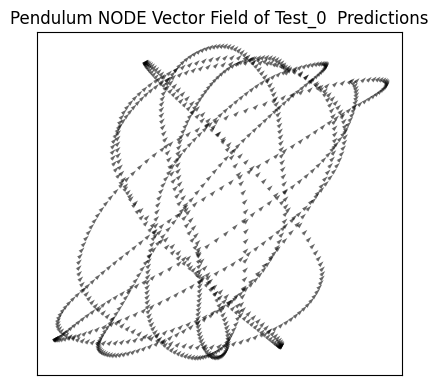

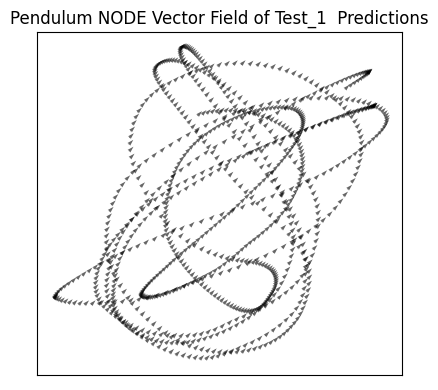

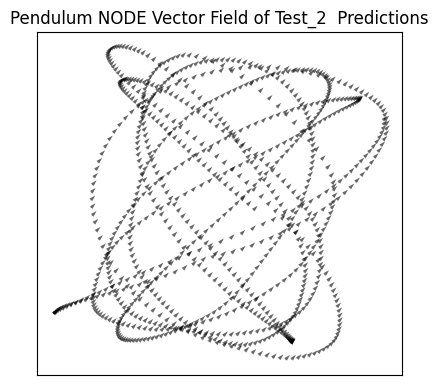

In [248]:
plot_vector_field(preds,label='Test')

In [219]:
train.shape

torch.Size([6, 1000, 4])

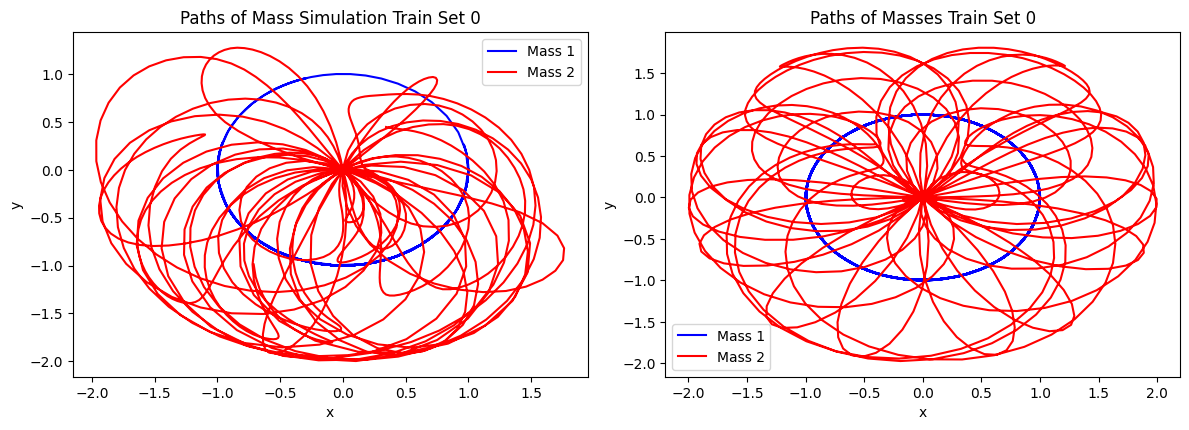

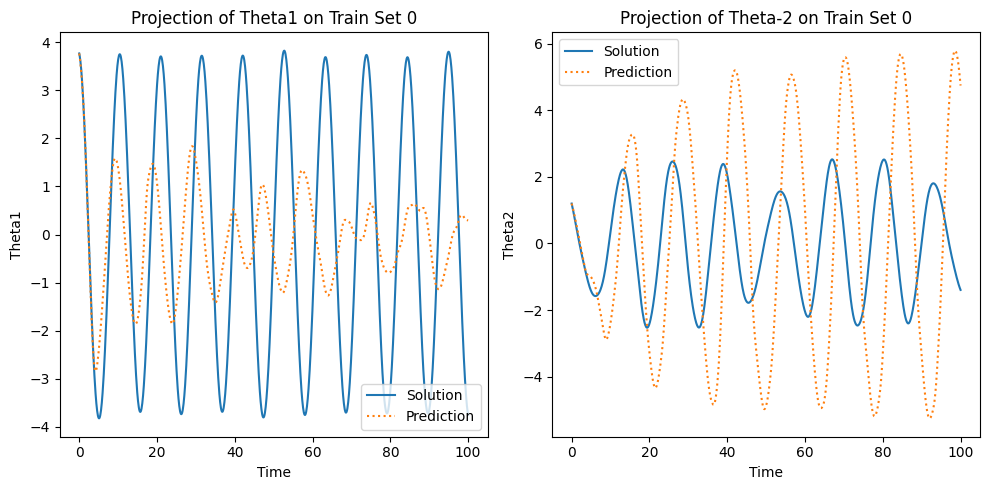

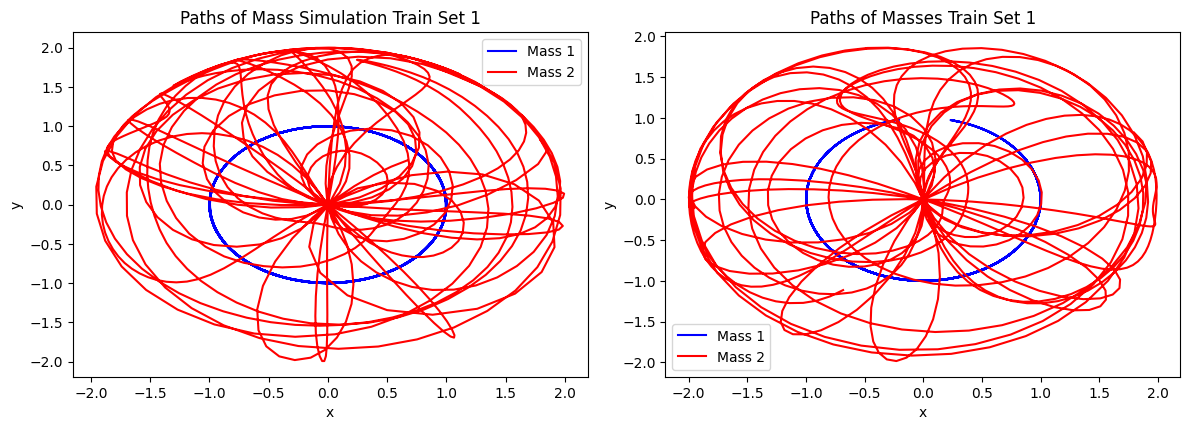

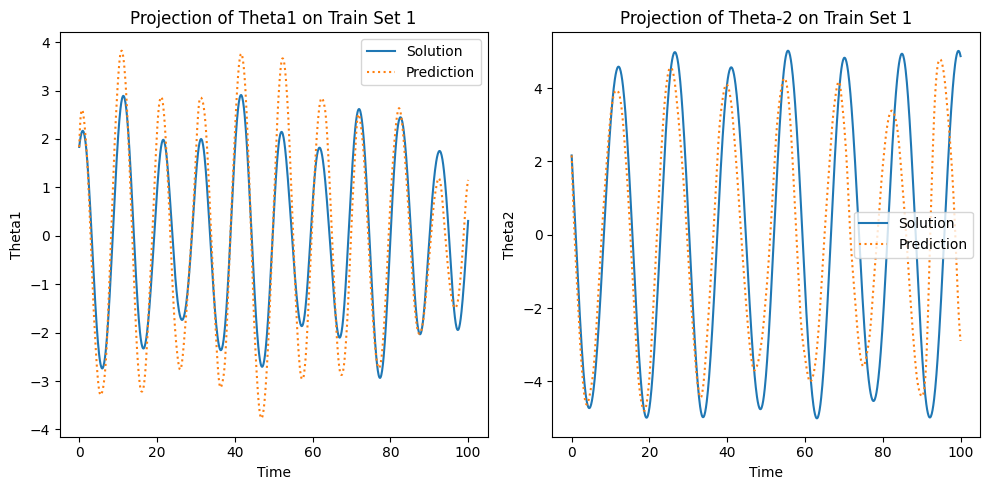

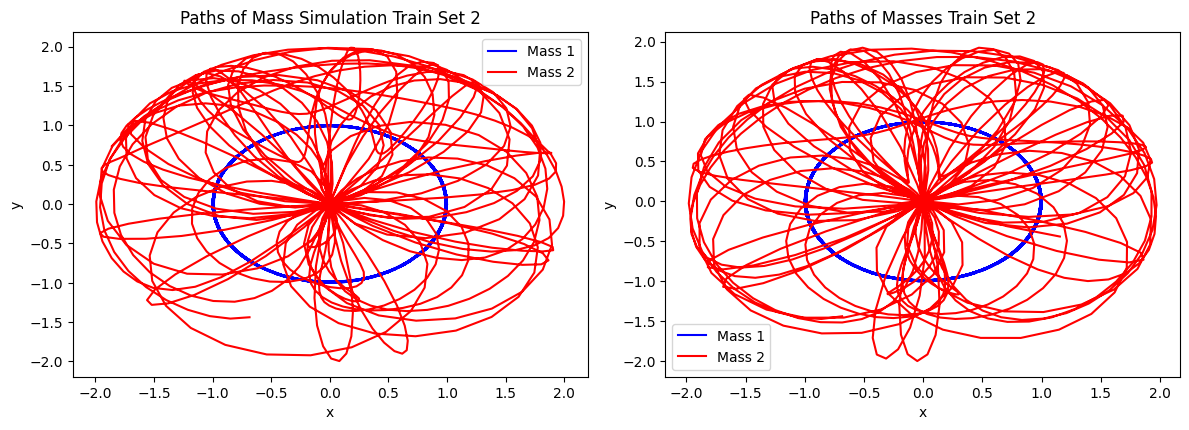

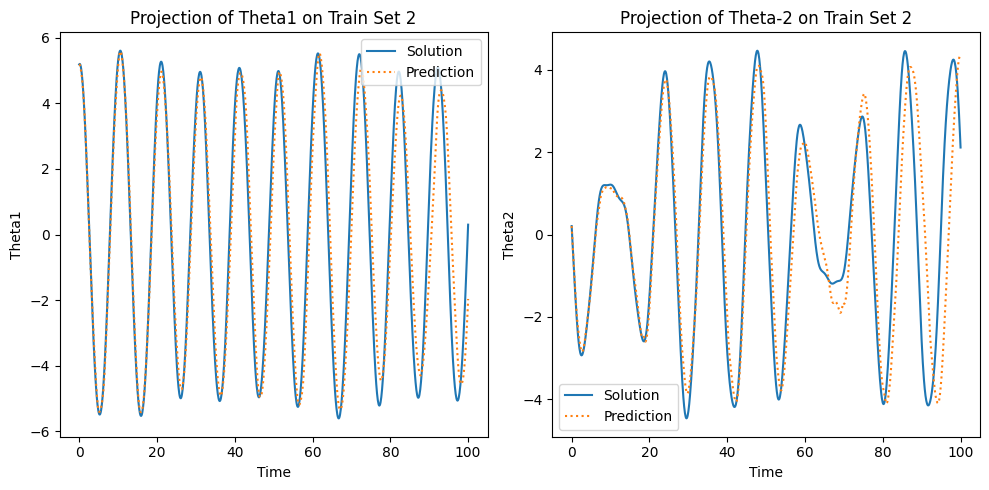

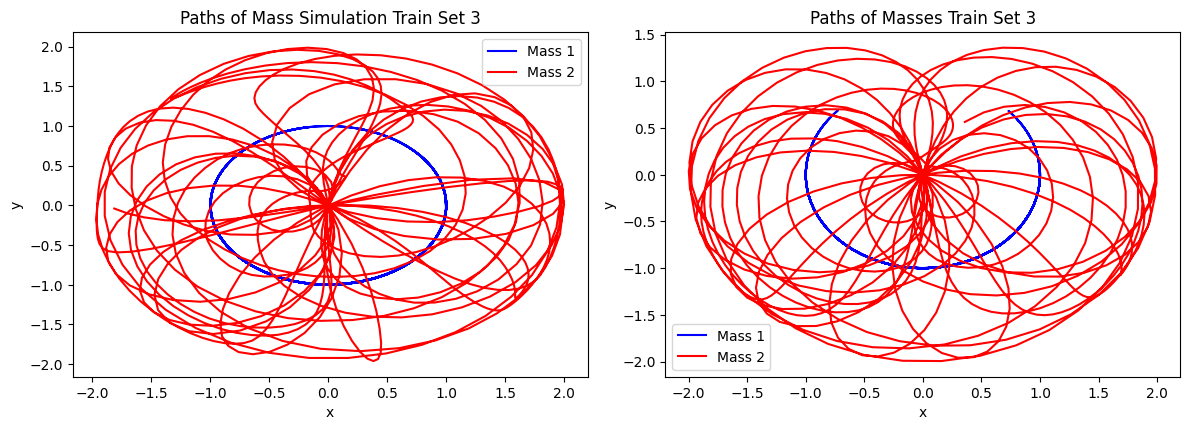

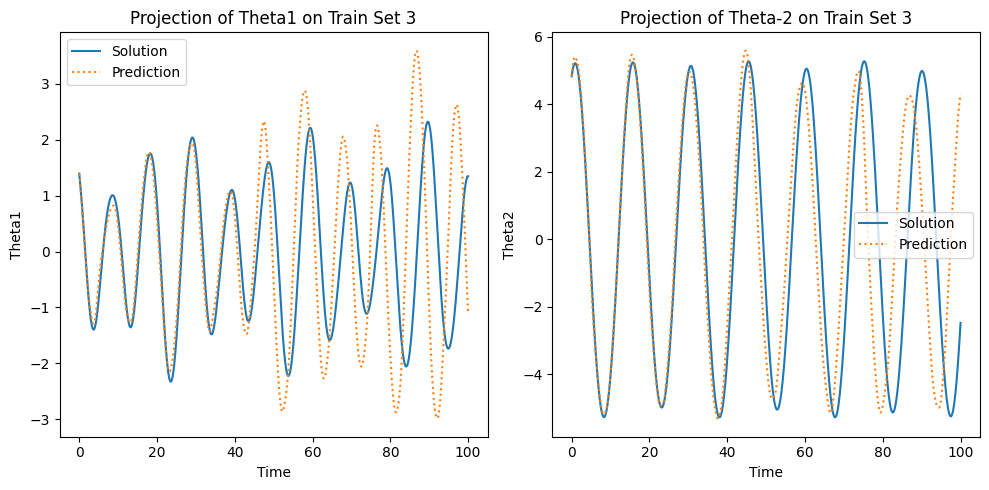

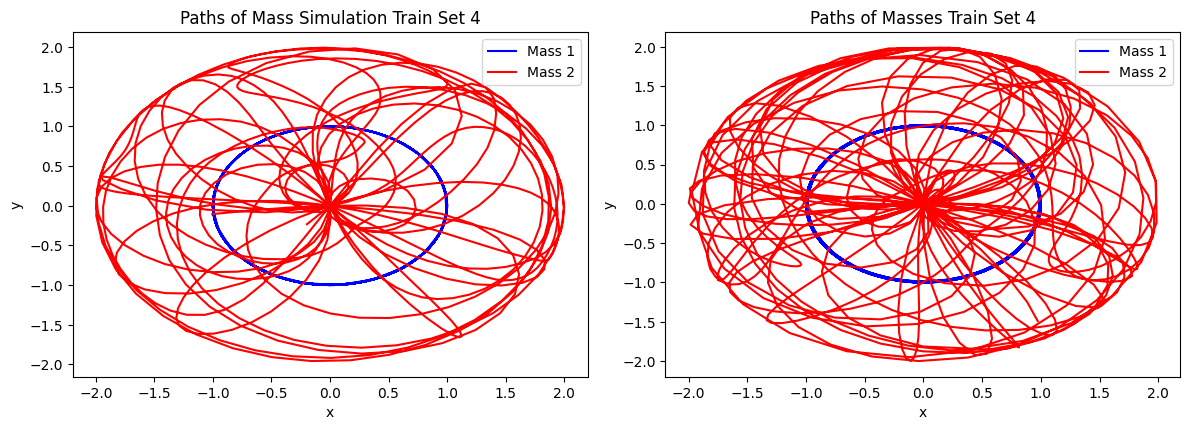

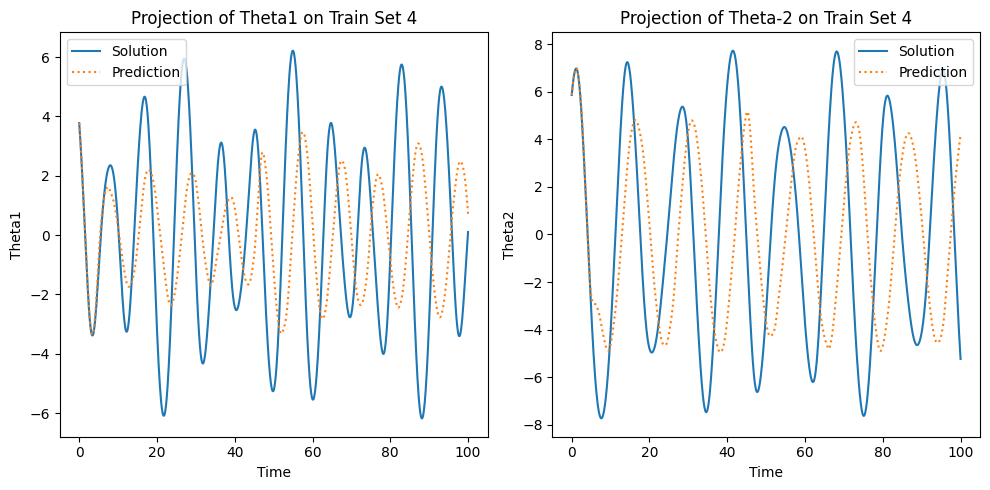

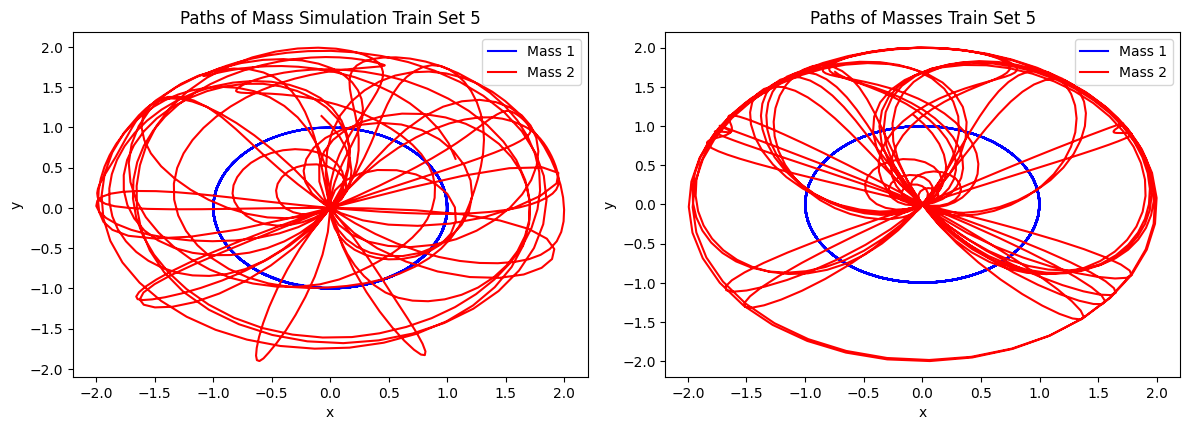

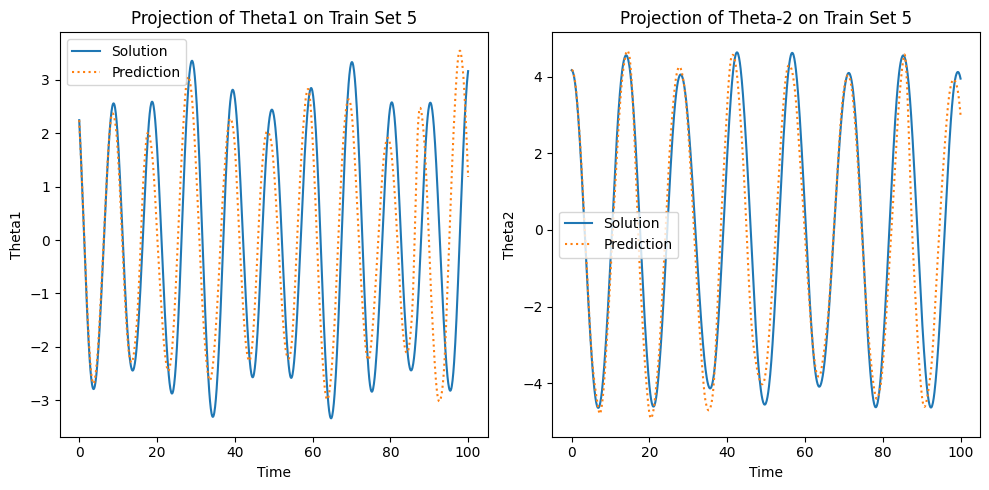

In [249]:
tr_losses,tr_preds = evaluate(test_model,data[:6],t,label='Train')

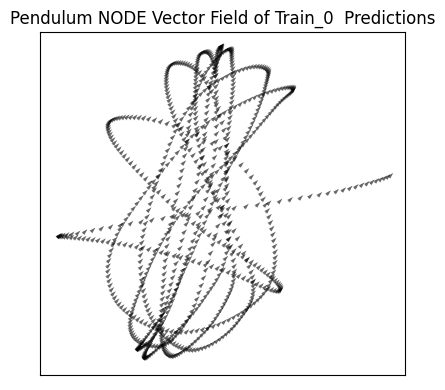

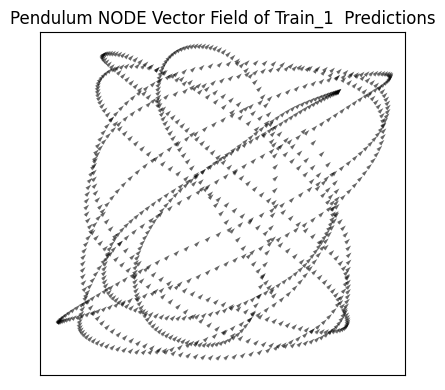

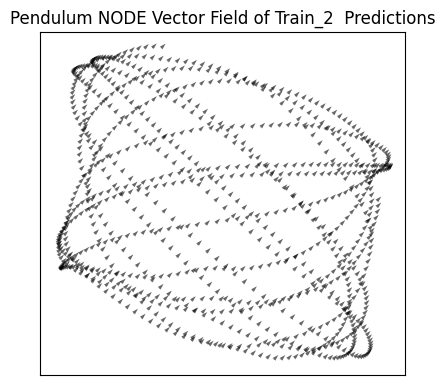

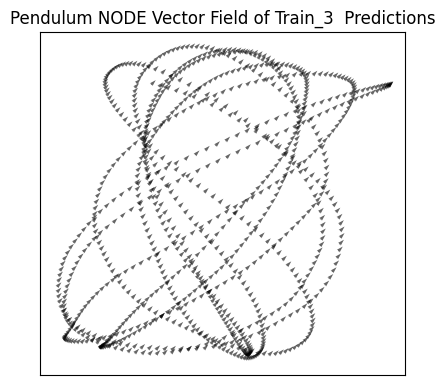

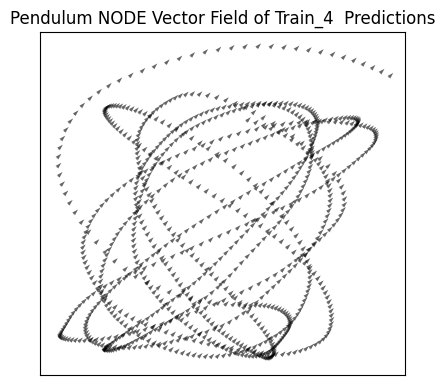

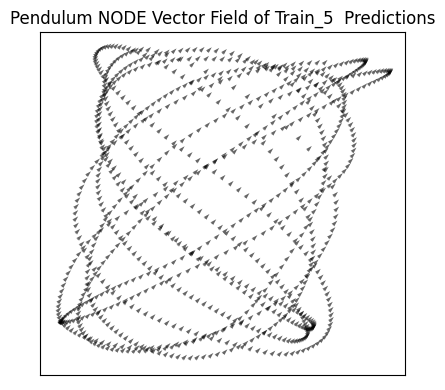

In [250]:
plot_vector_field(tr_preds,label='Train')